# Predicción con CNN

In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.model_selection import KFold
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv1D,  MaxPooling1D
from keras.callbacks import EarlyStopping, Callback
from IPython.display import clear_output
import random

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
# Trabajo en Google Colab
with open('/content/dfs.pkl', 'rb') as archivo:
    dfs = pickle.load(archivo)

In [4]:
len(dfs)

28

In [5]:
dfs[0].shape, dfs[0]

((347, 16),
 array([[0.7915103647248436, 0.2555500694510472, 0.7699380974337213, ...,
         False, False, False],
        [0.7865745330835447, 0.25505673403305545, 0.7747280572181771, ...,
         False, False, False],
        [0.783257652522349, 0.2498766661455021, 0.7779860729045281, ...,
         False, False, False],
        ...,
        [0.6364856902165876, 0.4375924946410434, 0.6253294989385919, ...,
         False, False, False],
        [0.6408687134853148, 0.49037984435256066, 0.6271023396941757, ...,
         False, False, False],
        [0.6467127411407548, 0.5022200093809627, 0.6308854307720998, ...,
         False, False, False]], dtype=object))

In [6]:
# Dividir en subsecuencias
def split_sequences(sequences, n_steps_in, n_steps_out):
  X = list()
  y = list()
  for split in sequences:
    for i in range(0, len(split), n_steps_out):
      end_ix = i + n_steps_in
      out_end_ix = end_ix + n_steps_out-1
      if out_end_ix > len(split):
        break
      else:
        seq_x = split[i:end_ix]
        seq_y = split[end_ix-1:out_end_ix, 0] # battery
      X.append(seq_x)
      y.append(seq_y)
  return np.asarray(X).astype('float32'), np.asarray(y).astype('float32')

In [7]:
seed = 0

In [8]:
# Definir modelo
def create_cnn_model(n_filters, n_kernel, n_steps_in, n_features, n_steps_out):
  model = Sequential()
  model.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu', input_shape=(n_steps_in, n_features)))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(n_steps_out, activation='sigmoid'))
  model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_similarity'])
  return model

Vamos a predecir 6*12 valores, es decir 12h adelante, y vamos a tomar como base el mismo número de valores.

## 12h

In [9]:
n_steps_in = n_steps_out = 6*12
print(n_steps_in)

72


In [10]:
# Crear datasets de entrenamiento y test
X, y = split_sequences(dfs, n_steps_in, n_steps_out)

n_features = X.shape[2]

In [11]:
X[0][0]

array([0.79151034, 0.25555006, 0.7699381 , 0.23867734, 0.        ,
       0.23443224, 0.04786121, 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        ], dtype=float32)

In [12]:
# Definir modelo
n_filters_list = [8, 16, 32, 64, 128]
n_kernel_list = [3, 5, 7, 9, 11]

best_params = None
best_loss = np.inf

for n_filters in n_filters_list:
  for n_kernel in n_kernel_list:
    print('------------------------------------------------------------------------')
    print(f'Entrenando para n_filters={n_filters} - n_kernels={n_kernel} ...')
    num_folds = 5

    loss_per_fold = []
    mae_per_fold = []
    mape_per_fold = []
    cs_per_fold = []
    history_per_fold = []

    # K-fold Cross Validation
    kfold = KFold(n_splits=num_folds, shuffle=True)

    fold_no = 1
    for train, test in kfold.split(X, y):
      # Crear modelo
      model = create_cnn_model(n_filters, n_kernel, n_steps_in, n_features, n_steps_out)
      print(f'\tEntrenando fold {fold_no} ...')
      # Entrenar modelo
      history = model.fit(X[train], y[train], validation_data=(X[test], y[test]), epochs=100, callbacks=[
                          EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=5, restore_best_weights=True)], verbose=0)
      # Evaluar modelo
      loss, mae, mape, cs = model.evaluate(X[test], y[test], verbose=0)
      # Guardar datos
      loss_per_fold.append(loss)
      mae_per_fold.append(mae)
      mape_per_fold.append(mape)
      cs_per_fold.append(cs)
      history_per_fold.append(history)
      # Guardamos modelo
      model.save(f'/content/cnn-12h-n_filters{n_filters}-n_kernels{n_kernel}-fold{fold_no}.keras')
      fold_no += 1

    # Medias
    print('------------------------------------------------------------------------')
    print('Puntuaciones por fold')
    for i in range(0, len(loss_per_fold)):
      print('------------------------------------------------------------------------')
      print(f'> Fold {i+1} - Loss: {round(loss_per_fold[i], 4)} - MAE: {round(mae_per_fold[i],4)} - MAPE: {round(mape_per_fold[i],4)} - CS: {round(cs_per_fold[i],4)}')
    print('------------------------------------------------------------------------')
    print('Medias de todos los folds:')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print(f'> MAE: {np.mean(mae_per_fold)}')
    print(f'> MAPE: {np.mean(mape_per_fold)}')
    print(f'> CS: {np.mean(cs_per_fold)}')
    print('------------------------------------------------------------------------')

    # Guardar mejores parametros de modelo
    loss_mean = np.mean(loss_per_fold)
    if loss_mean < best_loss:
      best_loss = loss_mean
      best_params = [n_filters, n_kernel]

print("\nMejor Loss:", best_loss)
print("Mejores Parámetros:", best_params)

------------------------------------------------------------------------
Entrenando para n_filters=8 - n_kernels=3 ...
	Entrenando fold 1 ...
	Entrenando fold 2 ...
	Entrenando fold 3 ...
	Entrenando fold 4 ...
	Entrenando fold 5 ...
------------------------------------------------------------------------
Puntuaciones por fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.0101 - MAE: 0.0721 - MAPE: 37.4233 - CS: 0.9913
------------------------------------------------------------------------
> Fold 2 - Loss: 0.0106 - MAE: 0.0703 - MAPE: 24.7667 - CS: 0.9903
------------------------------------------------------------------------
> Fold 3 - Loss: 0.0074 - MAE: 0.0603 - MAPE: 13471.5557 - CS: 0.9936
------------------------------------------------------------------------
> Fold 4 - Loss: 0.0074 - MAE: 0.0616 - MAPE: 12.1506 - CS: 0.9938
------------------------------------------------------------------------
> Fold 5 - Loss: 0.0098 - MAE: 0.06

In [51]:
print("Best n_filters:", best_params[0])
print("Best n_kernels:", best_params[1])

Best n_filters: 128
Best n_kernels: 11


In [ ]:
model = load_model(f'/content/cnn-12h-n_filters128-n_kernels11-fold2.keras')

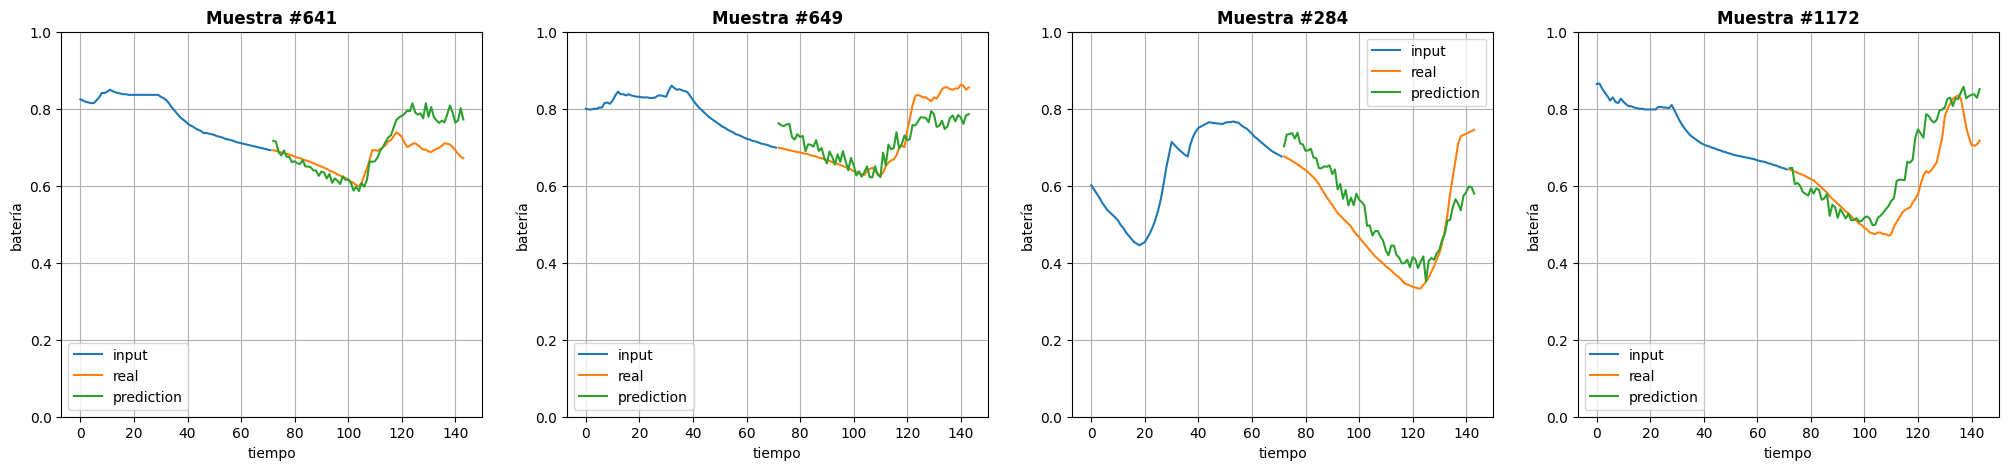

In [20]:
# Predicciones mostradas gráficamente del mejor modelo
f, axs = plt.subplots(1,4, figsize=(25, 5))
for w, ax in enumerate(axs):
  item = random.randint(0, len(X))
  yhat = model.predict(X[item].reshape(1, X[item].shape[0], X[item].shape[1]), verbose=0)
  ax.plot([i for i in range(n_steps_in)], X[item][:, 0], label='input')
  ax.plot([i for i in range(n_steps_in, n_steps_in+n_steps_out)], y[item], label='real')
  ax.plot([i for i in range(n_steps_in, n_steps_in+n_steps_out)], yhat[0], label='prediction')
  ax.set_ylim(0, 1)
  ax.set_xlabel('tiempo')
  ax.set_ylabel('batería')
  ax.set_title(f'Muestra #{item}', fontweight='600')
  ax.legend()
  ax.grid()
plt.show()


Vamos a hacer lo mismo con 6h y 24h.
## 6h

In [21]:
n_steps_in = n_steps_out = 6*6
print(n_steps_in, n_steps_out)

36 36


In [22]:
# Crear datasets de entrenamiento y test
X, y = split_sequences(dfs, n_steps_in, n_steps_out)

n_features = X.shape[2]

In [23]:
# Definir modelo
n_filters_list = [8, 16, 32, 64, 128]
n_kernel_list = [3, 5, 7, 9, 11]

best_params = None
best_loss = np.inf

for n_filters in n_filters_list:
  for n_kernel in n_kernel_list:
    print('------------------------------------------------------------------------')
    print(f'Entrenando para n_filters={n_filters} - n_kernels={n_kernel} ...')
    num_folds = 5

    loss_per_fold = []
    mae_per_fold = []
    mape_per_fold = []
    cs_per_fold = []
    history_per_fold = []

    # K-fold Cross Validation
    kfold = KFold(n_splits=num_folds, shuffle=True)

    fold_no = 1
    for train, test in kfold.split(X, y):
      # Crear modelo
      model = create_cnn_model(n_filters, n_kernel, n_steps_in, n_features, n_steps_out)
      print(f'\tEntrenando fold {fold_no} ...')
      # Entrenar modelo
      history = model.fit(X[train], y[train], validation_data=(X[test], y[test]), epochs=100, callbacks=[
                          EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=5, restore_best_weights=True)], verbose=0)
      # Evaluar modelo
      loss, mae, mape, cs = model.evaluate(X[test], y[test], verbose=0)
      # Guardar datos
      loss_per_fold.append(loss)
      mae_per_fold.append(mae)
      mape_per_fold.append(mape)
      cs_per_fold.append(cs)
      history_per_fold.append(history)
      # Guardamos modelo
      model.save(f'/content/cnn-6h-n_filters{n_filters}-n_kernels{n_kernel}-fold{fold_no}.keras')
      fold_no += 1

    # Medias
    print('------------------------------------------------------------------------')
    print('Puntuaciones por fold')
    for i in range(0, len(loss_per_fold)):
      print('------------------------------------------------------------------------')
      print(f'> Fold {i+1} - Loss: {round(loss_per_fold[i], 4)} - MAE: {round(mae_per_fold[i],4)} - MAPE: {round(mape_per_fold[i],4)} - CS: {round(cs_per_fold[i],4)}')
    print('------------------------------------------------------------------------')
    print('Medias de todos los folds:')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print(f'> MAE: {np.mean(mae_per_fold)}')
    print(f'> MAPE: {np.mean(mape_per_fold)}')
    print(f'> CS: {np.mean(cs_per_fold)}')
    print('------------------------------------------------------------------------')

    # Guardar mejores parametros de modelo
    loss_mean = np.mean(loss_per_fold)
    if loss_mean < best_loss:
      best_loss = loss_mean
      best_params = [n_filters, n_kernel]

print("\nMejor Loss:", best_loss)
print("Mejores Parámetros:", best_params)

------------------------------------------------------------------------
Entrenando para n_filters=8 - n_kernels=3 ...
	Entrenando fold 1 ...
	Entrenando fold 2 ...
	Entrenando fold 3 ...
	Entrenando fold 4 ...
	Entrenando fold 5 ...
------------------------------------------------------------------------
Puntuaciones por fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.0089 - MAE: 0.0644 - MAPE: 44.3439 - CS: 0.994
------------------------------------------------------------------------
> Fold 2 - Loss: 0.0091 - MAE: 0.0677 - MAPE: 15.0995 - CS: 0.9947
------------------------------------------------------------------------
> Fold 3 - Loss: 0.0079 - MAE: 0.0621 - MAPE: 13.6126 - CS: 0.9956
------------------------------------------------------------------------
> Fold 4 - Loss: 0.008 - MAE: 0.0624 - MAPE: 13.5312 - CS: 0.9949
------------------------------------------------------------------------
> Fold 5 - Loss: 0.0089 - MAE: 0.0644 - 

In [24]:
print("Best n_filters:", best_params[0])
print("Best n_kernels:", best_params[1])

Best n_filters: 64
Best n_kernels: 3


In [25]:
model = load_model(f'/content/cnn-6h-n_filters64-n_kernels3-fold2.keras')

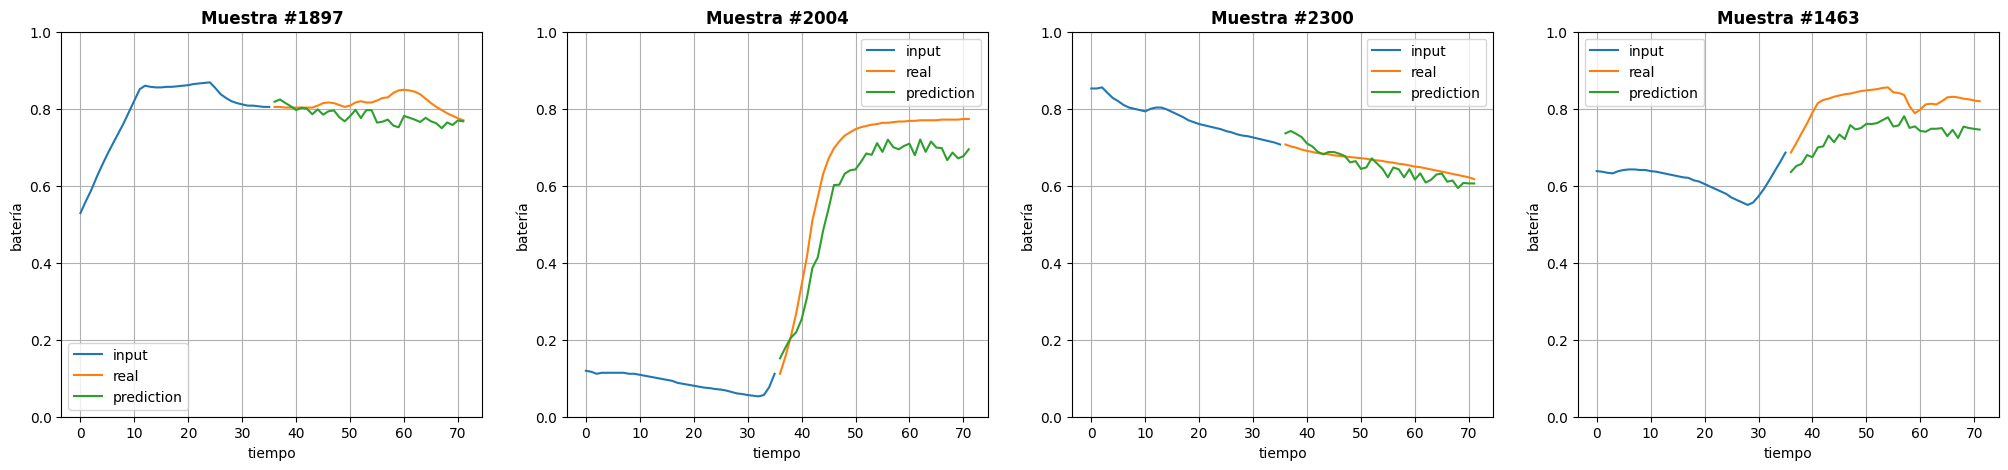

In [41]:
# Predicciones mostradas gráficamente del mejor modelo
f, axs = plt.subplots(1,4, figsize=(25, 5))
for w, ax in enumerate(axs):
  item = random.randint(0, len(X))
  yhat = model.predict(X[item].reshape(1, X[item].shape[0], X[item].shape[1]), verbose=0)
  ax.plot([i for i in range(n_steps_in)], X[item][:, 0], label='input')
  ax.plot([i for i in range(n_steps_in, n_steps_in+n_steps_out)], y[item], label='real')
  ax.plot([i for i in range(n_steps_in, n_steps_in+n_steps_out)], yhat[0], label='prediction')
  ax.set_ylim(0, 1)
  ax.set_xlabel('tiempo')
  ax.set_ylabel('batería')
  ax.set_title(f'Muestra #{item}', fontweight='600')
  ax.legend()
  ax.grid()
plt.show()


## 24h

In [42]:
n_steps_in = n_steps_out = 6*24
print(n_steps_in, n_steps_out)

144 144


In [43]:
# Crear datasets de entrenamiento y test
X, y = split_sequences(dfs, n_steps_in, n_steps_out)

n_features = X.shape[2]

In [44]:
# Definir modelo
n_filters_list = [8, 16, 32, 64, 128]
n_kernel_list = [3, 5, 7, 9, 11]

best_params = None
best_loss = np.inf

for n_filters in n_filters_list:
  for n_kernel in n_kernel_list:
    print('------------------------------------------------------------------------')
    print(f'Entrenando para n_filters={n_filters} - n_kernels={n_kernel} ...')
    num_folds = 5

    loss_per_fold = []
    mae_per_fold = []
    mape_per_fold = []
    cs_per_fold = []
    history_per_fold = []

    # K-fold Cross Validation
    kfold = KFold(n_splits=num_folds, shuffle=True)

    fold_no = 1
    for train, test in kfold.split(X, y):
      # Crear modelo
      model = create_cnn_model(n_filters, n_kernel, n_steps_in, n_features, n_steps_out)
      print(f'\tEntrenando fold {fold_no} ...')
      # Entrenar modelo
      history = model.fit(X[train], y[train], validation_data=(X[test], y[test]), epochs=100, callbacks=[
                          EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=5, restore_best_weights=True)], verbose=0)
      # Evaluar modelo
      loss, mae, mape, cs = model.evaluate(X[test], y[test], verbose=0)
      # Guardar datos
      loss_per_fold.append(loss)
      mae_per_fold.append(mae)
      mape_per_fold.append(mape)
      cs_per_fold.append(cs)
      history_per_fold.append(history)
      # Guardamos modelo
      model.save(f'/content/cnn-24h-n_filters{n_filters}-n_kernels{n_kernel}-fold{fold_no}.keras')
      fold_no += 1

    # Medias
    print('------------------------------------------------------------------------')
    print('Puntuaciones por fold')
    for i in range(0, len(loss_per_fold)):
      print('------------------------------------------------------------------------')
      print(f'> Fold {i+1} - Loss: {round(loss_per_fold[i], 4)} - MAE: {round(mae_per_fold[i],4)} - MAPE: {round(mape_per_fold[i],4)} - CS: {round(cs_per_fold[i],4)}')
    print('------------------------------------------------------------------------')
    print('Medias de todos los folds:')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print(f'> MAE: {np.mean(mae_per_fold)}')
    print(f'> MAPE: {np.mean(mape_per_fold)}')
    print(f'> CS: {np.mean(cs_per_fold)}')
    print('------------------------------------------------------------------------')

    # Guardar mejores parametros de modelo
    loss_mean = np.mean(loss_per_fold)
    if loss_mean < best_loss:
      best_loss = loss_mean
      best_params = [n_filters, n_kernel]

print("\nMejor Loss:", best_loss)
print("Mejores Parámetros:", best_params)

------------------------------------------------------------------------
Entrenando para n_filters=8 - n_kernels=3 ...
	Entrenando fold 1 ...
	Entrenando fold 2 ...
	Entrenando fold 3 ...
	Entrenando fold 4 ...
	Entrenando fold 5 ...
------------------------------------------------------------------------
Puntuaciones por fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.0066 - MAE: 0.057 - MAPE: 11.9579 - CS: 0.9937
------------------------------------------------------------------------
> Fold 2 - Loss: 0.0086 - MAE: 0.0625 - MAPE: 15.3046 - CS: 0.9921
------------------------------------------------------------------------
> Fold 3 - Loss: 0.0079 - MAE: 0.0611 - MAPE: 23.62 - CS: 0.9912
------------------------------------------------------------------------
> Fold 4 - Loss: 0.0076 - MAE: 0.0628 - MAPE: 13.496 - CS: 0.9937
------------------------------------------------------------------------
> Fold 5 - Loss: 0.0109 - MAE: 0.07 - MAPE

In [45]:
print("Best n_filters:", best_params[0])
print("Best n_kernels:", best_params[1])

Best n_filters: 128
Best n_kernels: 11


In [48]:
model = load_model(f'/content/cnn-24h-n_filters128-n_kernels11-fold3.keras')

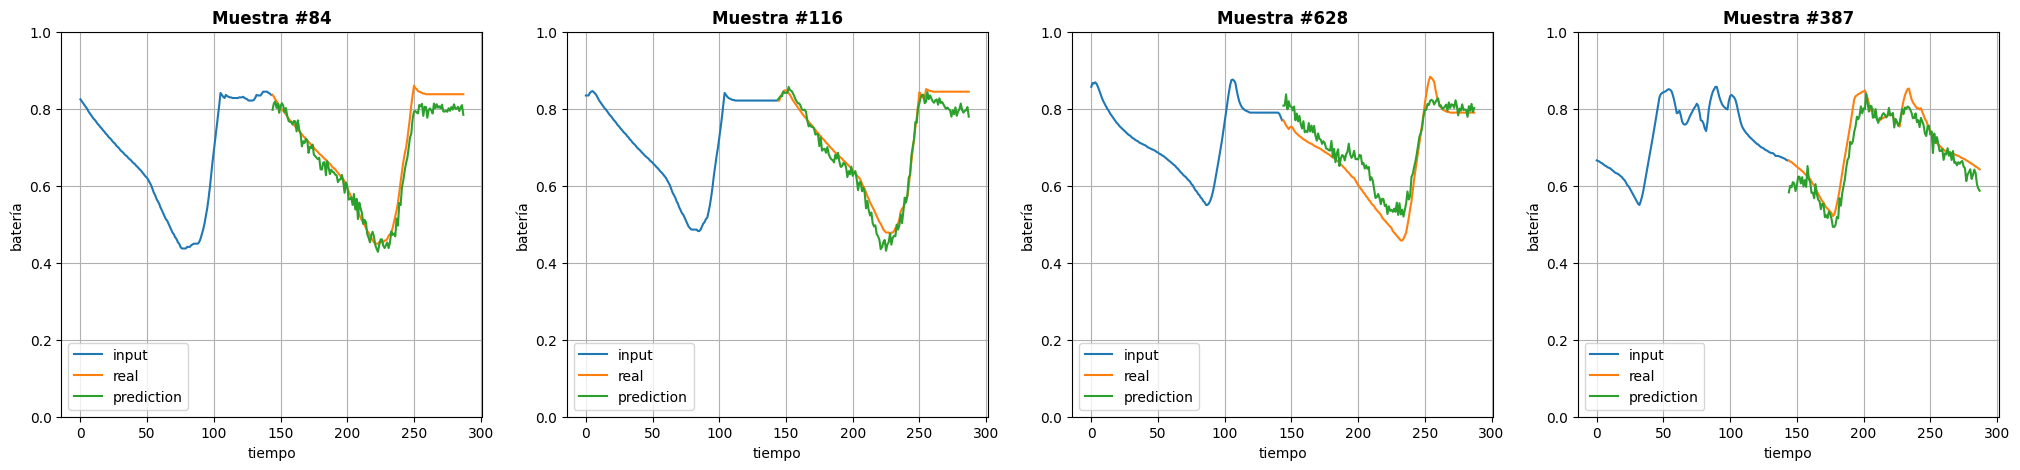

In [49]:
# Predicciones mostradas gráficamente del mejor modelo
f, axs = plt.subplots(1,4, figsize=(25, 5))
for w, ax in enumerate(axs):
  item = random.randint(0, len(X))
  yhat = model.predict(X[item].reshape(1, X[item].shape[0], X[item].shape[1]), verbose=0)
  ax.plot([i for i in range(n_steps_in)], X[item][:, 0], label='input')
  ax.plot([i for i in range(n_steps_in, n_steps_in+n_steps_out)], y[item], label='real')
  ax.plot([i for i in range(n_steps_in, n_steps_in+n_steps_out)], yhat[0], label='prediction')
  ax.set_ylim(0, 1)
  ax.set_xlabel('tiempo')
  ax.set_ylabel('batería')
  ax.set_title(f'Muestra #{item}', fontweight='600')
  ax.legend()
  ax.grid()
plt.show()
